# Boundary Value Problems

### Homework 1


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: np.exp(x)   # right-hand side function
u_true = lambda x: (4.0 - np.exp(1.0)) * x - 1.0 + np.exp(x)  # exact solution

##### Question 1 – Implement the solver

Write a Python function that constructs and solves the finite difference approximation of the BVP:

In [30]:
def solve_bvp(a, b, u_a, u_b, f, m):
    """
    Solve the boundary value problem:
        u''(x) = f(x),  x ∈ [a, b],
        u(a) = u_a,  u(b) = u_b

    Parameters
    ----------
    a : float
        Left boundary point
    b : float
        Right boundary point
    u_a : float
        Boundary condition at x = a
    u_b : float
        Boundary condition at x = b
    f : callable
        Function f(x) on the right-hand side
    m : int
        Number of interior grid points

    Returns
    -------
    x_bc : ndarray
        Array of all grid points including boundaries
    U : ndarray
        Approximate solution at all grid points
    """

    # Step 1: Discretize domain
    # x_bc = numpy.linspace(...)
    # x = interior points
    # h = step size
    x_bc = np.linspace(a, b, m+2)
    x = x_bc[1:-1]
    h = (b-a)/(m+1)

    # Step 2: Build matrix A (size m x m) for finite difference operator
    m = x.shape[0]
    d1 = np.ones(m-1)
    d2 = -2*np.ones(m)

    A = (1/h**2) * (np.diag(d2) + np.diag(d1, 1) + np.diag(d1, -1))

    # Step 3: Build RHS vector, including boundary adjustments
    F = f(x) 
    F[0] = F[0] - u_a/h**2
    F[-1] = F[-1] - u_b/h**2

    # Step 4: Solve linear system for interior values
    U = np.linalg.solve(A, F)
    
    # Step 5: Reconstruct full solution with boundary values
    U = np.concatenate(([u_a], U, [u_b]))

    return x_bc, U

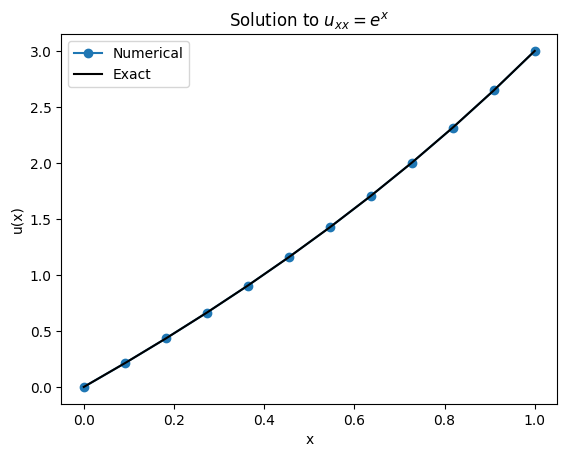

In [31]:
m = 10
x_bc, U = solve_bvp(a, b, u_a, u_b, f, m)

plt.plot(x_bc, U, 'o-', label="Numerical")
plt.plot(x_bc, u_true(x_bc), 'k', label="Exact")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Solution to $u_{xx} = e^x$")
plt.legend()
plt.show()

##### Question 2 – Convergence analysis


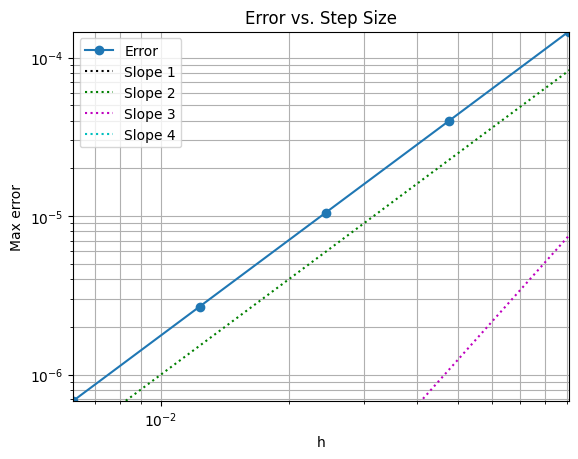

In [35]:
m_values = [10, 20, 40, 80, 160]
errors = []
hs = []

for m in m_values:
    points, U_it = solve_bvp(a, b, u_a, u_b, f, m)
    error = np.max(np.abs(U_it - u_true(points)))
    errors.append(error)
    hs.append((b - a) / (m + 1))

hvec = 1.0 / 2**np.arange(30)

plt.loglog(hs, errors, marker='o', label="Error")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")
plt.xlim([min(hs), max(hs)])
plt.ylim([min(errors), max(errors)])
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.legend()
plt.grid(True, which='both')

We can clearly see that our converge order is 2, since its parallel to slope 2 from the previous tasks.

---
#### **Homework 2:**

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Exact solution and RHS
u_exact = lambda x: -(5.0 + np.e) * x - (2.0 + np.e + np.exp(-1.0)) + np.exp(x)
f = lambda x: np.exp(x)

# Domain and boundary data
a, b = -1.0, 1.0
alpha = u_exact(a)   # Dirichlet at x=-1
sigma = -5.0         # Neumann at x=1

##### Task 1 — Implement solver functions

Write **three Python functions**, one for each way of enforcing the Neumann boundary condition:

1. **First-order one-sided** difference

   $$
   u'(1) \approx \frac{u_N - u_{N-1}}{h} = \sigma
   $$

2. **Second-order one-sided** difference

   $$
   u'(1) \approx \frac{-3u_N + 4u_{N-1} - u_{N-2}}{2h} = \sigma
   $$

3. **Second-order centered (ghost point)**
   Introduce ghost point $u_{N+1}$ and use

   $$
   u'(1) \approx \frac{u_{N+1} - u_{N-1}}{2h} = \sigma 
   \quad \Rightarrow \quad u_{N+1} = u_{N-1} + 2h\sigma
   $$


In [ ]:
def solve_bvp_neumann(a, b, alpha, sigma, f, m, method="first_order"):
    """
    Solve u''(x) = f(x), x in [a,b],
    with u(a)=alpha and u'(b)=sigma.

    Parameters
    ----------
    a, b : floats
        Interval boundaries
    alpha : float
        Dirichlet boundary value at x=a
    sigma : float
        Neumann boundary value at x=b
    f : callable
        Function f(x) on RHS
    m : int
        Number of interior points
    method : str
        "first_order", "one_sided_2nd", or "centered_2nd"

    Returns
    -------
    x_bc : ndarray
        Grid points including boundaries
    U : ndarray
        Approximate solution at all grid points
    """
    # Step 1: build grid
    x_bc = np.linspace(a, b, m+2)
    x = x_bc[1:-1]
    h = (b-a)/(m+1)
    
    # Step 2: build matrix A (m x m) for finite differences
    m = x.shape[0]
    d1 = np.ones(m-1)
    d2 = -2*np.ones(m)
    A = (1/h**2) * (np.diag(d2) + np.diag(d1, 1) + np.diag(d1, -1))

    # Step 3: build RHS vector b_vec = f(x)
    F = f(x)

    # Step 4: enforce u(a)=alpha (Dirichlet)
    F[0] -= alpha / h**2

    # Step 5: enforce u'(b)=sigma depending on `method`
    if method == 'first_order':
        A[-1, -1] = -1/h**2
        A[-1, -2] = 1/h**2
        F[-1] -= sigma / h

    elif method == 'one_sided_2nd':
        A[-1, -1] = -(2/3) / h**2
        A[-1, -2] = (2/3) / h**2
        F[-1] -= (2/3) * sigma/h

    elif method == 'centered_2nd':
        A[-1, -1] = -2/(3*h**2)
        A[-1, -2] = 2/(3*h**2)
        F[-1] -=  (2/3) * sigma/h
    # Step 6: solve system, reconstruct full solution
    U_int = np.linalg.solve(A, F)

    if method == 'first_order':
        u_b = U_int[-1] + h*sigma

    elif method == 'one_sided_2nd':
        u_b = (2*h*sigma + 4*U_int[-1] - U_int[-2]) / 3
    
    elif method == 'centered_2nd':
        u_b = (4*U_int[-1] - U_int[-2] + 2*h*sigma)/3.0 # found with Taylor 

    U = np.concatenate(([alpha], U_int, [u_b]))

    return x_bc, U

##### Task 2 — Test your solver

Use:

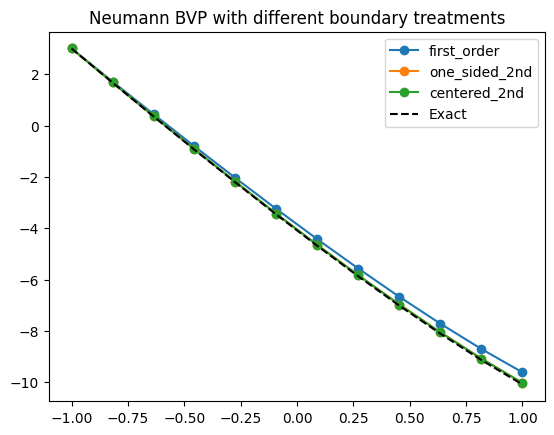

In [60]:
m = 10
for method in ["first_order", "one_sided_2nd", "centered_2nd"]:
    x_bc, U = solve_bvp_neumann(a, b, alpha, sigma, f, m, method)
    plt.plot(x_bc, U, 'o-', label=f"{method}")
plt.plot(x_bc, u_exact(x_bc), 'k--', label="Exact")
plt.legend()
plt.title("Neumann BVP with different boundary treatments")
plt.show()

##### Task 3 — Convergence study

1. Choose a sequence of grid sizes:

   ```python
   m_values = [10, 20, 40, 80, 160]
   ```
2. For each method and each `m`:

   * compute solution with `solve_bvp_neumann`,
   * compute step size $h = (b-a)/(m+1)$,
   * compute error:

     ```python
     error = np.max(np.abs(U - u_exact(x_bc)))
     ```
3. Compute the **observed order of accuracy** between successive grid sizes:

   $$
   p = \frac{\log(E_k / E_{k+1})}{\log(h_k / h_{k+1})}.
   $$
4. Make a **table** with columns: `m, h, error, p`.
5. Plot **error vs h** in log-log scale for each method.

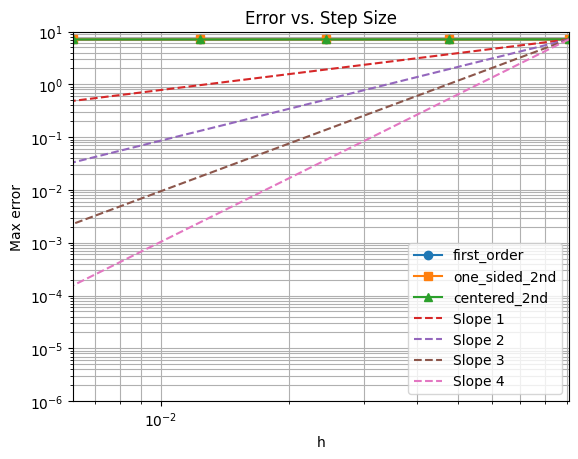

           method         h     error
0     first_order  0.090909  7.206665
1     first_order  0.047619  7.150044
2     first_order  0.024390  7.119091
3     first_order  0.012346  7.102884
4     first_order  0.006211  7.094589
5   one_sided_2nd  0.090909  7.093844
6   one_sided_2nd  0.047619  7.088333
7   one_sided_2nd  0.024390  7.086740
8   one_sided_2nd  0.012346  7.086311
9   one_sided_2nd  0.006211  7.086199
10   centered_2nd  0.090909  7.093844
11   centered_2nd  0.047619  7.088333
12   centered_2nd  0.024390  7.086740
13   centered_2nd  0.012346  7.086311
14   centered_2nd  0.006211  7.086199


In [98]:
m_values = [10, 20, 40, 80, 160]
methods = ["first_order", "one_sided_2nd", "centered_2nd"]
results = {}

for method in methods:
    errors = []
    hs = []
    for m in m_values:
        points, U_it = solve_bvp_neumann(a, b, alpha, sigma, f, m, method)
        error = np.max(np.abs(U_it - u_exact(points)))
        h = (b - a) / (m + 1)
        errors.append(error)
        hs.append(h)
    results[method] = {"h": np.array(hs), 
                       "errors": np.array(errors)}


# a plot for each method
plt.figure()
for method , mk in zip(methods, ['o', 's', '^']):
    hs = results[method]["h"]
    errors = results[method]["errors"]
    plt.loglog(hs, errors, marker=mk, label=method)

ref = results["centered_2nd"]       # usa el método de mayor orden como referencia
x0 = ref["h"][0]                    # punto de anclaje (el h más grande, a la derecha)
y0 = ref["errors"][0]

hvec = 1.0 / 2**np.arange(10)       # misma idea que antes: 1/2^k
for p in [1, 2, 3, 4]:
    plt.loglog(x0*hvec, y0*(hvec**p), '--', label=f'Slope {p}')

plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.xlim([min(hs), max(hs)])
plt.ylim([1e-6, 10])
plt.grid(True, which='both')
plt.legend()
plt.show()

# print a table 
rows = []
for method, vals in results.items():
    for h, err in zip(vals["h"], vals["errors"]):
        rows.append({"method": method, "h": h, "error": err})

df = pd.DataFrame(rows)

print(df)          # en consola



We can see that first order has, obviously, first order convergence, while the other two has second order convergence.